In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
mean_gray = 0.2860
stddev_gray = 0.3530

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray, ), (stddev_gray, ))])

train_dataset = datasets.FashionMNIST(root = './data',
                                      train = True,
                                      transform = transform,
                                      download = True)

test_dataset = datasets.FashionMNIST(root = './data',
                                      train = False,
                                      transform = transform,
                                      download = False)

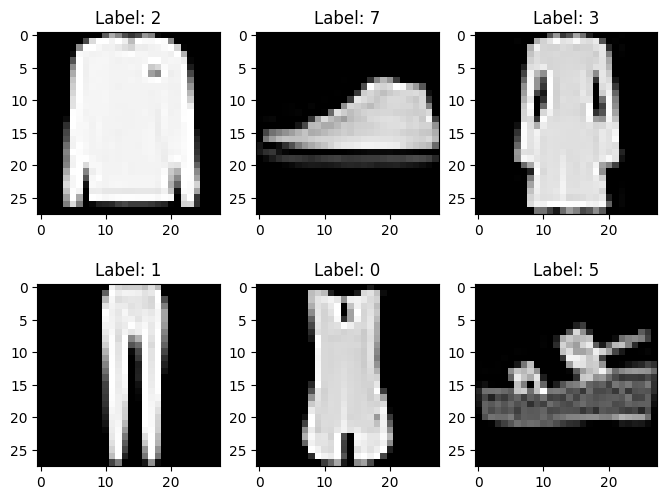

In [73]:
fig, axes = plt.subplots(2 ,3, figsize = (8,6))

for i, image_number in enumerate(torch.randint(low = 0, high = 100, size = (6,))):
    ax = axes[i // 3, i % 3]
    ax.imshow(train_dataset.data[image_number], cmap = 'gray')
    ax.set_title("Label: " + str(train_dataset.targets[image_number].item()))

In [5]:
batch_size = 100

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = batch_size,
                          shuffle = False)

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        # output size: 28
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        # output size: 14

        self.cnn2 = nn.Conv2d(in_channels = 8, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        self.batchnorm2 = nn.BatchNorm2d(32) 
        # output size: 14

        self.fc1 = nn.Linear(7*7*32, 600)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(600, 10)
    def forward(self, x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = out.view(-1, 7*7*32)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


In [28]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()
optimalizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [42]:
# Train the CNN

num_epochs = 5
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()

        optimalizer.zero_grad()
        loss.backward()
        optimalizer.step()
        
        _ , predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(correct / len(train_dataset))

    iter_loss = 0.0
    correct = 0
    iterations = 0

    model.eval()
    for i, (inputs, labels) in enumerate(test_loader):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        iter_loss += loss.item()

        _ , predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    test_loss.append(iter_loss/iterations)
    test_accuracy.append(correct / len(test_dataset))
    print("Epoch: {}/ {}, Train loss: {:.3f}, Train accuracy: {:.3f}, Test loss: {:.3f}, Test accuracy: {:.3f}".format(
        epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1]
    ))


Epoch: 1/ 5, Train loss: 0.281, Train accuracy: 0.898, Test loss: 0.272, Test accuracy: 0.905
Epoch: 2/ 5, Train loss: 0.268, Train accuracy: 0.903, Test loss: 0.287, Test accuracy: 0.899
Epoch: 3/ 5, Train loss: 0.265, Train accuracy: 0.904, Test loss: 0.274, Test accuracy: 0.904
Epoch: 4/ 5, Train loss: 0.256, Train accuracy: 0.905, Test loss: 0.281, Test accuracy: 0.906
Epoch: 5/ 5, Train loss: 0.250, Train accuracy: 0.909, Test loss: 0.283, Test accuracy: 0.905


In [ ]:
image = test_dataset[30][0].view(1,1,28,28)
label = test_dataset[30][1]

model.eval()
outputs = model(image)
_,predicted = torch.max(outputs, 1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label)) 

Prediction is: 8
Actual is: 8
